# Zillow Predictions

## Goal:
Using a ML Regression model, my goal is to predict property tax assesed value of Single Family Propeties using key drivers. <br>
**Initial Questions:**
1. What is defined as a Single Family Property?
    - "a standalone, detached house used as a single dwelling unit"
2. Could how old the houses are play a factor into this?
3. Where are most houses located?
4. Between bedrooms and bathrooms, which has a higher drive for tax value?

## Planning:
1. Data Acquisition:
    - Aquire the zillow dataset
2. Data Peperation:
    - Clean the dataframe:
        - Remove outliers
        - Nulls
        - Create a data dictionary
        - Create a graph of locations for Maggie
        - Split data into train, validate, test
3. Explore the data:
    - Look a univate stats: analysis of infividual data
    - Look at Bivariate stats: analysis of interactions between the target and features
    - look a multivare stats: analysis of interactions of 3+ variables
4. Modeling:
    - Feature engineering
    - Create a Ordinary Least Sqaures 
    - Lasso + Lars
    - Polynomial Regression
    - Generalized Linear Model

### Before we can start: Imports

In [1]:
#generalized imports:
import numpy as np
import pandas as pd

# python files:
import wrangle as wr
import explore as ex
import modeling as md

# visualization:
import matplotlib.pyplot as plt
import seaborn as sns


# stats
from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# models: 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars

# Data Aquistion: 
For undestanding: 
- `get_zillow_data()` from wranlge will import the `zillow` data from the MySQL database.
- Data that was requested from 2017 transactions: 
    - SQFT
    - number of bedrooms
    - number of bathrooms

In [2]:
# aqcuire the data frame: 
df = wr.get_zillow_data()
df.head()

,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,taxvaluedollarcnt,propertylandusetypeid,propertylandusedesc,yearbuilt
0,2017-01-13,2.0,3.0,1324.0,6037.0,518089.0,261.0,Single Family Residential,1963.0
1,2017-01-13,3.0,4.0,3551.0,6037.0,1609238.0,261.0,Single Family Residential,1994.0
2,2017-01-13,3.0,4.0,2519.0,6037.0,106406.0,261.0,Single Family Residential,1965.0
3,2017-01-13,2.0,3.0,1285.0,6037.0,369853.0,261.0,Single Family Residential,1955.0
4,2017-01-13,1.0,3.0,1254.0,6037.0,65848.0,261.0,Single Family Residential,1954.0


In [3]:
df.propertylandusedesc.value_counts()

Single Family Residential    52441
Name: propertylandusedesc, dtype: int64

In [4]:
df.transactiondate.max()

'2017-09-25'

### Initial questions after looking into the data: 
Could these features be factors? 
- `yearbuilt` : How old the house is?
- `lotsizesqaurefeet` : How big is the property?
- `numberofstories` : Does number of stories influence purchase? (need to remove outliers to make data normal)

Features that were looked into but don't look reliable(outliers)
- `fullbathcnt` : This is the same as bathroomcnt
- `roomcnt` : How many rooms are there, is this even actuarte? (Not reliable)

# Data Preperation: 
For understaning:
- `clean_zillow()` will remove nulls, drop unwanted columns, and rename columns to a more legible format
- `create_columns()` will feature eningeer some new columns that look at how old the housees are and how many rooms there are based on bathrooms and bedrroms
- `remove_outliers()` will remove outliers from the first quartile and the third quartile

In [5]:
# looking at the data threre are nulls: 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transactiondate               52441 non-null  object 
 1   bathroomcnt                   52441 non-null  float64
 2   bedroomcnt                    52441 non-null  float64
 3   calculatedfinishedsquarefeet  52359 non-null  float64
 4   fips                          52441 non-null  float64
 5   taxvaluedollarcnt             52440 non-null  float64
 6   propertylandusetypeid         52441 non-null  float64
 7   propertylandusedesc           52441 non-null  object 
 8   yearbuilt                     52325 non-null  float64
dtypes: float64(7), object(2)
memory usage: 4.0+ MB


In [6]:
# what percentage of the data base is missing?
df.isna().sum()/ df.shape[0] * 100

transactiondate                 0.000000
bathroomcnt                     0.000000
bedroomcnt                      0.000000
calculatedfinishedsquarefeet    0.156366
fips                            0.000000
taxvaluedollarcnt               0.001907
propertylandusetypeid           0.000000
propertylandusedesc             0.000000
yearbuilt                       0.221201
dtype: float64

>The nulls that are missing only make up 0.1 %, 0.2 %, and 0.001% percent of the data base, so it would be safe to drop these values since we are only losing about half a percent of the data

In [7]:
# lets clean it up:
df = wr.clean_zillow(df)
df.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt
0,2.0,3.0,1324.0,518089.0,1963.0
1,3.0,4.0,3551.0,1609238.0,1994.0
2,3.0,4.0,2519.0,106406.0,1965.0
3,2.0,3.0,1285.0,369853.0,1955.0
4,1.0,3.0,1254.0,65848.0,1954.0


> I want to make new columns for how old the house is when the house was bought (2017-yearbuilt) and for bedrooms and bathrooms combined

In [8]:
# lets create those columns:
df = wr.create_columns(df)
df.head()

,bathrooms,bedrooms,sqft,tax_value,yearbuilt,house_age,bb_roomcnt
0,2.0,3.0,1324.0,518089.0,1963.0,54.0,5.0
1,3.0,4.0,3551.0,1609238.0,1994.0,23.0,7.0
2,3.0,4.0,2519.0,106406.0,1965.0,52.0,7.0
3,2.0,3.0,1285.0,369853.0,1955.0,62.0,5.0
4,1.0,3.0,1254.0,65848.0,1954.0,63.0,4.0


> After doing some exploring through the data I came to the conclusion that I wanted to remove some outliers

In [9]:
# example of crazy numbers:
df.bedrooms.value_counts()

3.0     23348
4.0     15228
2.0      8333
5.0      3970
6.0       633
1.0       605
7.0       106
0.0        57
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedrooms, dtype: int64

> What single value house has 14 bedrooms or 18 bathrooms?

Visualize the outliers:

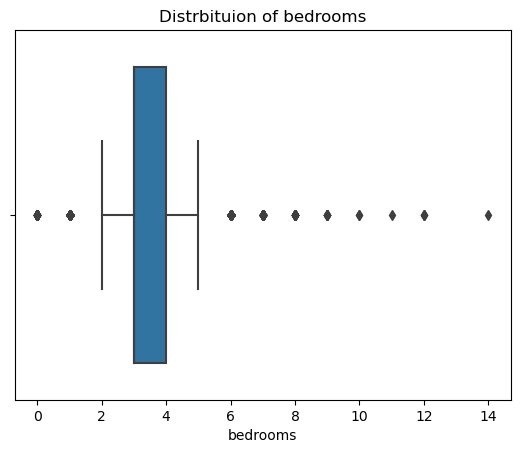

In [10]:
plt.title('Distrbituion of bedrooms')
sns.boxplot(data=df, x='bedrooms')
plt.show()

In [11]:
# lets check if it is okay to remove the outliers?
df.shape

(52319, 7)

> There are 52319 rows, or customers

In [12]:
# lets remove the outliers:
all_columns = df.columns
df = wr.remove_outliers(df, 3, all_columns)
df.shape

(50231, 7)

> For understaning: Using a k of 3 would give bathrooms an uper bound of 7, meaning we would remove anything beyond 7 bathrooms

In [13]:
#how much data is lost?
((52319 - 50231)/55812) * 100 

3.7411309395828853

> We only lose 3.7% of the data removing outliers

Isn't that better? <br>

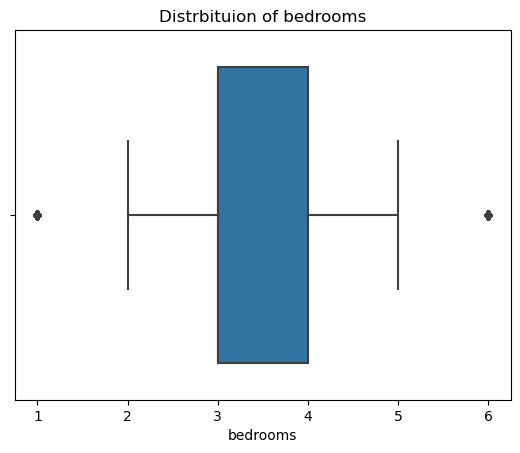

In [14]:
plt.title('Distrbituion of bedrooms')
sns.boxplot(data=df, x='bedrooms')
plt.show()

### Split the data into train, validate, test: 

In [15]:
# split the data:
train_1, validate_1, test_1  = wr.prep_zillow()

### Scale the data:
- scaling helps out with models

In [16]:
# scale the data:
to_scale = ['bedrooms','bathrooms','sqft','yearbuilt','house_age','bb_roomcnt']
train, validate, test = ex.scale_data(train_1, validate_1, test_1, to_scale)

# Exploration Summary: 

### Univarite Summary: 
- The largest count of bathrooms 5.5. Data looks normally distributed.
- The largest count of bedrooms is 6. Data looks normally distributed.
- SQFT has a postive skew. The highest amount of SQFT is 5303!
- Year built: There are some old, OLD, houses! Who gets an **1878's** house?
- House age: Again, old houses. Youngest is 1 year old. The data has a negative skew.
- Bedroom+Bathroom count: The higest amount of rooms was 11.5.
- Target Varible: has a positive skew. Higest value: **$1,829,696**. That is alot of money! 

### Bi/Multivariate Summary (key features):
- Based on the Heatmap: The top 3 features with the strongest correlation:
    - Sqft -> positive correlation
    - Bathrooms -> postive correlation
    - bb_count -> psotive correlation
    - House_age <- negative correlation

## Lets ask some questions! Hypothesis testing: 
Q1. Is there a relationship between `sqft` and tax value? <br>
Q2. Is there a relationship between `batrooms` and tax value? <br>
Q3. Is there a realtionship between `house_age` and tax value? <br>
Q4. Is there a relationship between `roomcnt` and tax value? <br>

### 1. Is there a realtionship between sqft and tax value?
- $H_0$: There is no monotonic relationship between sqft and tax value.
- $H_a$: There is a montonic relationship between sqft and tax value.

In [17]:
# evalute the data. It is not normally distributed
α=0.05
r, p = spearmanr(train.tax_value, train.sqft)
if p < α:
        print(f"""We reject H₀, there is a monotonic relationship.
            Spearman’s r: {r:2f}
            P-value: {p}""")
else:
        print(f"""We fail to reject H₀: that there is a monotonic relationship.
                    Spearman’s r: {r:2f}
                    P-value: {p}""")

We reject H₀, there is a monotonic relationship.
            Spearman’s r: 0.486425
            P-value: 0.0


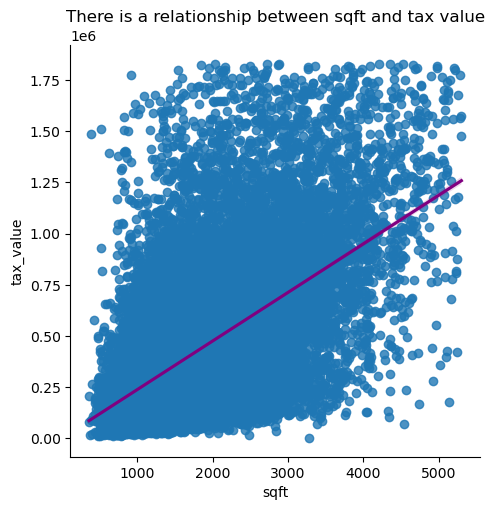

In [18]:
# lets make a graph: 
sns.lmplot(data=train_1, x ='sqft', y = 'tax_value',palette = 'flare' ,line_kws={'color':'purple'})
plt.title("There is a relationship between sqft and tax value")
plt.show()

### 2. Is there a realtionship between bathrooms and tax value?
- $H_0$: There is no monotonic relationship between bathrooms and tax value.
- $H_a$: There is a montonic relationship between bathrooms and tax value.

In [19]:
#evavlute the data using an eval function
r, p = spearmanr(train.tax_value, train.sqft)
ex.eval_Spearman(r, p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.486425
P-value: 0.0


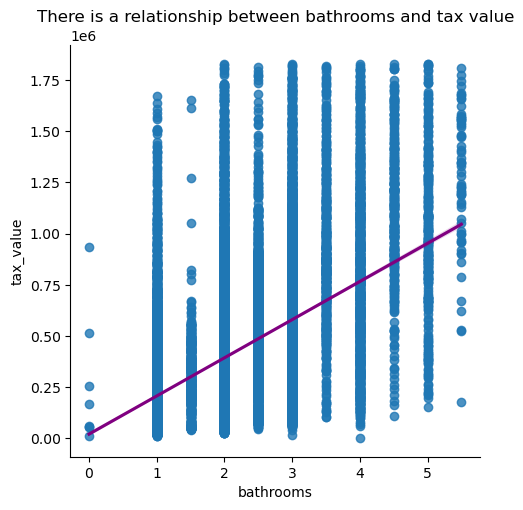

In [20]:
# lets make a graph: 
sns.lmplot(data=train_1, x ='bathrooms', y = 'tax_value',palette = 'flare' ,line_kws={'color':'purple'})
plt.title("There is a relationship between bathrooms and tax value")
plt.show()

### 3. Is there a realtionship between house_age and tax value?
- $H_0$: There is no monotonic relationship between house age and tax value.
- $H_a$: There is a montonic relationship between house age and tax value.

In [21]:
# evalute the data
r, p = spearmanr(train.tax_value, train.house_age)
ex.eval_Spearman(r, p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: -0.265323
P-value: 0.0


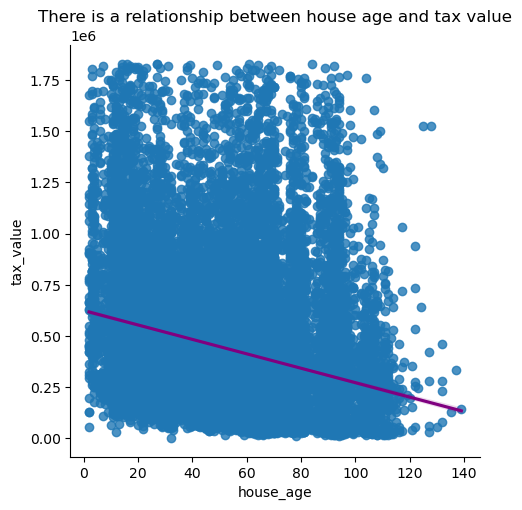

In [22]:
# lets make a graph: 
sns.lmplot(data=train_1, x ='house_age', y = 'tax_value',palette = 'flare' ,line_kws={'color':'purple'})
plt.title("There is a relationship between house age and tax value")
plt.show()

### 4. Is there a realtionship between bb_roomcnt and tax value?
- $H_0$: There is no monotonic relationship between bb_roomcnt and tax value.
- $H_a$: There is a montonic relationship between bb_roomcnt and tax value.

In [23]:
# evalute: 
r, p = spearmanr(train.tax_value, train.bb_roomcnt)
ex.eval_Spearman(r, p )

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.386785
P-value: 0.0


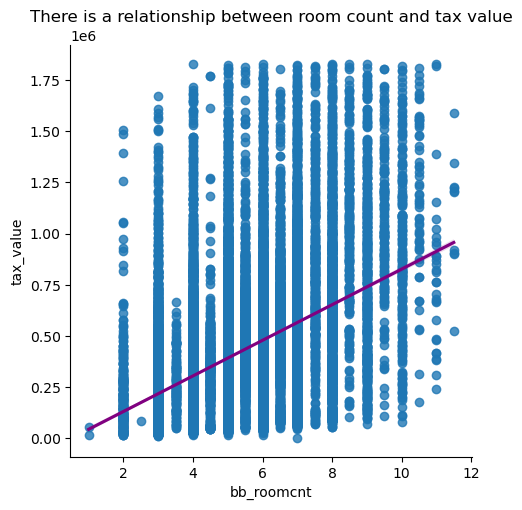

In [24]:
# lets make a graph: 
sns.lmplot(data=train_1, x ='bb_roomcnt', y = 'tax_value',palette = 'flare' ,line_kws={'color':'purple'})
plt.title("There is a relationship between room count and tax value")
plt.show()

# Modeling: 
- So based on explore our top 3 features are: 
    - SQFT
    - Bathrooms
    - House age
- Mean is the better baseline to work with
- Made 7 Models using:
    - Ordinary Least Sqaures 
    - Lasso + Lars
    - Polynomial Regression
    - Generalized Linear Model
- RFE best features were:
    - Bathrooms
    - Year Built
    - House age

### Top 3 Models: 
- The top 3 models were: 
    1. Polynomial Regression, degree = 2
    2. Lasso + Lars
    3. Ordinary Least Sqaures using all features

In [25]:
# create our X and y features: 
X_train = train.drop(columns = 'tax_value')
y_train = train['tax_value']

X_validate = validate.drop(columns= 'tax_value')
y_validate = validate['tax_value']

X_test = test.drop(columns = 'tax_value')
y_test = test['tax_value']

In [26]:
# lets make our baseline: 
baseline = y_train.mean()
baseline

432836.7569681456

In [27]:
# return a dataframe for comparinson (baseline predictions)
eval_df = md.evaluate_baseline(y_train)
eval_df

,model,rmse,r2
0,baseline,331483.636429,0.0


### Ordinary Least Sqaures

In [28]:
# make the model: 
lr = LinearRegression()
#fit the model
lr.fit(X_train, y_train)
#evalute
rmse, r_2 = md.evaluate_reg(y_train, lr.predict(X_train))
#add to the data frame: 
eval_df = md.add_eval_df('ols_all_features', rmse, r_2, eval_df)
eval_df

,model,rmse,r2
0,baseline,331483.636429,0.000000
1,ols_all_features,270821.486189,0.332514


In [29]:
# add the validate 
val_rmse, val_r2 = md.evaluate_reg(y_validate, lr.predict(X_validate))
val_dict = {
    'model': 'ols_all_features',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}
val_scores = [val_dict]

### Polynomial Regression

In [30]:
# make the object
pf = PolynomialFeatures(degree=2)

#fit the object
x_train_sq = pf.fit_transform(X_train)

# use this on validate
x_val_sq = pf.transform(X_validate)

# make a new model for polynomial regressor: 
plyreg = LinearRegression()
plyreg.fit(x_train_sq, y_train)

# evalute the model
rmse, r_2 = md.evaluate_reg(y_train, plyreg.predict(x_train_sq))

In [31]:
# add it to our df: 
eval_df = md.add_eval_df('quad_reg', rmse, r_2, eval_df)
eval_df

,model,rmse,r2
0,baseline,331483.636429,0.000000
1,ols_all_features,270821.486189,0.332514
2,quad_reg,269493.914669,0.339042


In [32]:
# add the validate 
val_rmse, val_r2 = md.evaluate_reg(y_validate, plyreg.predict(x_val_sq))
val_dict = {
    'model': 'quad_reg',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}
val_scores.append(val_dict)

### LassoLars

In [33]:
# make it
lasso = LassoLars(alpha=1)
# fit it:
lasso = lasso.fit(X_train, y_train)
# evalute
rmse, r_2 = md.evaluate_reg(y_train, lasso.predict(X_train))
# add it to the dataframe
eval_df = md.add_eval_df('lassolars', rmse, r_2, eval_df)
eval_df

,model,rmse,r2
0,baseline,331483.636429,0.000000
1,ols_all_features,270821.486189,0.332514
2,quad_reg,269493.914669,0.339042
3,lassolars,270856.206398,0.332343


In [34]:
# add the validate 
val_rmse, val_r2 = md.evaluate_reg(y_validate, lasso.predict(X_validate))
val_dict = {
    'model': 'lassolars',
    'val_rmse': val_rmse,
    'val_r2': val_r2
}
val_scores.append(val_dict)

### What is the best model? Could it be overfit?
- Core Evaluation: 
1. RMSE:
how much error does the typical prediction has
same units as the target
**smaller** is better
2. R2:
variance in y (target) explained by X (predictor)
closer to **1** is better
- I looked at the visualizatoin of the predictions and residuals on a scatter but there were many dots and it look muddled due to the large amount of points

In [35]:
eval_df

,model,rmse,r2
0,baseline,331483.636429,0.000000
1,ols_all_features,270821.486189,0.332514
2,quad_reg,269493.914669,0.339042
3,lassolars,270856.206398,0.332343


In [36]:
val_scores = pd.DataFrame(val_scores)
val_scores

,model,val_rmse,val_r2
0,ols_all_features,274423.303126,0.319668
1,quad_reg,272952.036970,0.326944
2,lassolars,274429.492276,0.319638


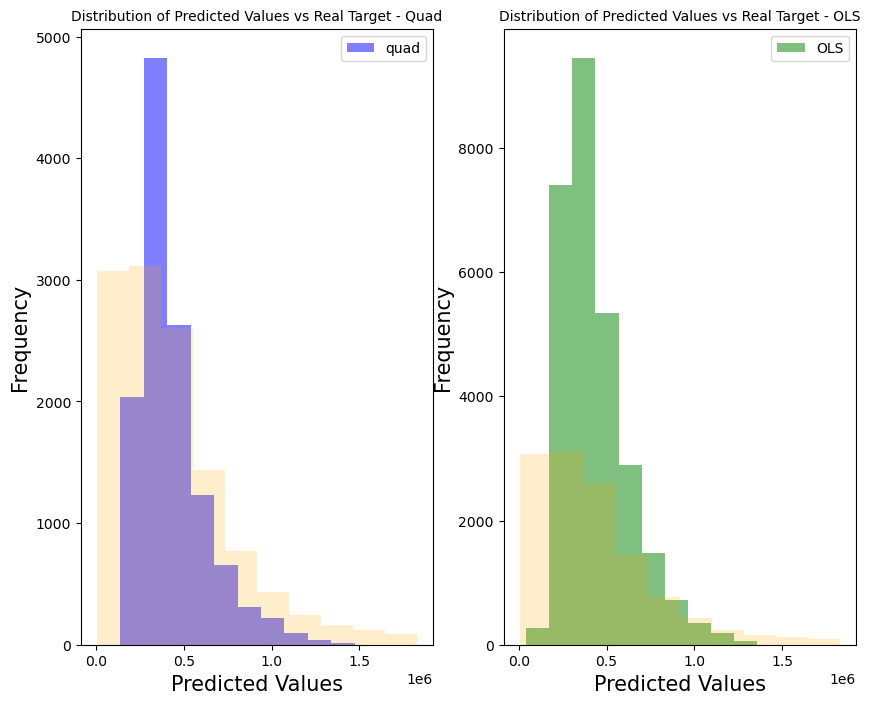

In [41]:
# lets look at some graphs:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.hist(plyreg.predict(x_val_sq), alpha=0.5, label='quad', color='blue')
plt.hist(y_validate, alpha=0.2, color='orange')
plt.legend()
plt.title('Distribution of Predicted Values vs Real Target - Quad', fontsize=10)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

# Plotting the second histogram (lasso)
plt.subplot(1, 2, 2)
plt.hist(lr.predict(X_train), alpha=0.5, label='OLS', color='green')
plt.hist(y_validate, alpha=0.2, color='orange')
plt.legend()
plt.title('Distribution of Predicted Values vs Real Target - OLS', fontsize=10)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

# Show the plots
plt.show()

> The Polinomial Regression is has a lower RMSE, by about $1,363. This means its error is much less indicating it can save more money then the other model.

# Use the model on test:

In [38]:
# predict the model on test: 
x_test_sq = pf.transform(X_test)

#use the model: 
rmse, r_2 = md.evaluate_reg(y_test, plyreg.predict(x_test_sq))

rmse, r_2

(275690.3955116248, 0.328986211012141)

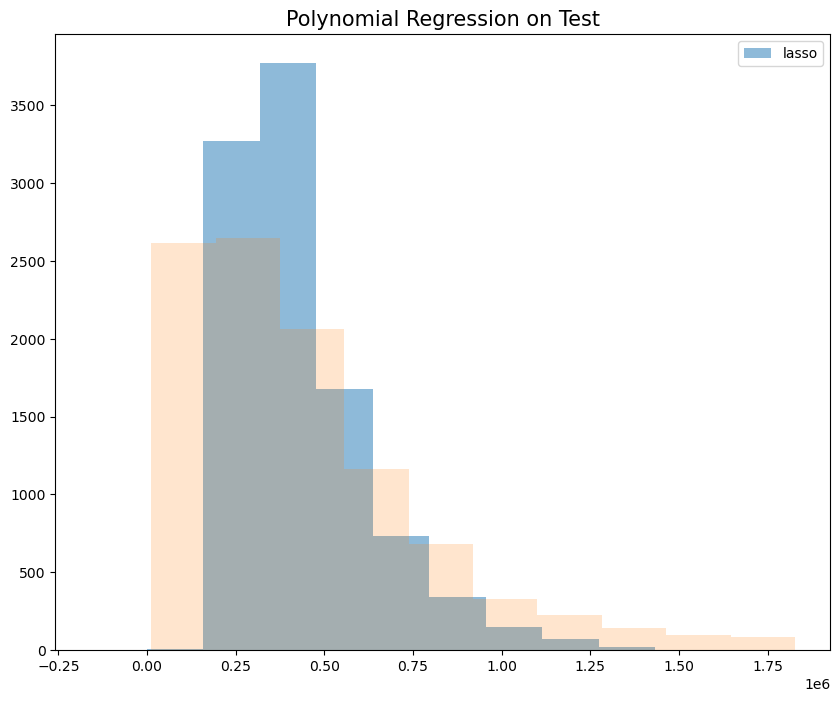

In [42]:
plt.figure(figsize=(10,8))
plt.hist(plyreg.predict(x_test_sq), alpha=0.5, label='lasso')
plt.hist(y_test, alpha=0.2)
plt.legend()
plt.title('Polynomial Regression on Test', fontsize=15)
plt.show()

# Modeling Summary: 
- Polynomial Regression preformed the best with our given data set
- The best features in explore did not end up being the best features in modeling.
- There is still a large mean sqaured error. 
- If there is a better model, I would remocomend using it until I can prodcuce a model with lower rsme.

# Conclusion: 
1. Summary:
    - Polynomial Regression was the best preforming model
    - SQFT, bedrooms, and bathrooms increase tax value
    - House age decreased tax value
2. Recomendations: 
    - I would consider not selling older houses. These houses tend to lower the amount of profit that can be made of. 
    - I would recomend advertising larger homes or smaller homes with a large number of bathrooms. It seems that bathrooms are very sought after comidity.
3. Next steps:
    - I would take a look at the data relative the the locations of the house. Specifically each county that they are in.
    - I would also take more time and add new features, such as how many stories each single residental property has. If the propety has a pool, and so on.
    - look at what the best features may be differnet than the ones that were shown in the heatmap correlation test.